# Tips: About different data same box plot

Recipes for Explodatory Data Analysis by means of plots

- toc: true 
- badges: true
- comments: false
- categories: [r,ggplot,recipes]


*TOC*
* write a function for generating random data with (almost) same stats


 



As in my previous post I was fascinated by sets of data having same basic stats and also same boxplot. (since I'm a chemist the funny stuff was to use simulated annealing since It reminds me whan I was a student and first had a look at them) You can have a  look at this [page](https://www.autodesk.com/research/publications/same-stats-different-graphs) to find all details. Since the plot also looks a lot like a kind of diffraction pattern I tried a simple idea I had in mind. **What if taking as reference the basics stats I will generate normal distributions that have as mean the median, q1, q3, min, max** 
If I keep the everything "simmetric enough" (I know this is a term that does not exists) and cut in half the distibution at the min and max it should work. So starting from the datasaurus

      left              lines               normal          right       
 Min.   :-9.76964   Min.   :-9.769575   Min.   :-9.76   Min.   :-9.760  
 1st Qu.:-2.68999   1st Qu.:-2.689993   1st Qu.:-2.68   1st Qu.:-2.680  
 Median :-0.00999   Median :-0.007132   Median : 0.00   Median : 0.000  
 Mean   :-1.17780   Mean   :-0.831733   Mean   : 0.00   Mean   : 1.174  
 3rd Qu.: 2.67007   3rd Qu.: 2.670236   3rd Qu.: 2.68   3rd Qu.: 2.680  
 Max.   : 9.75025   Max.   : 9.756001   Max.   : 9.76   Max.   : 9.760  
     split          
 Min.   :-9.769886  
 1st Qu.:-2.689989  
 Median :-0.003099  
 Mean   :-0.003060  
 3rd Qu.: 2.680000  
 Max.   : 9.760000  

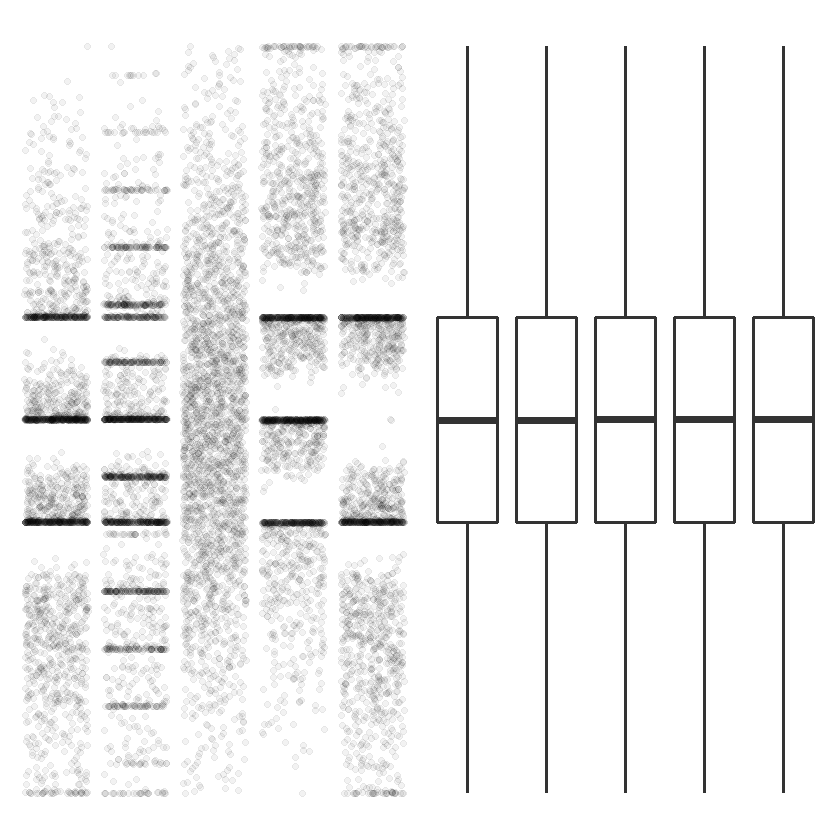

In [7]:
library(data.table)
library(ggplot2)
library(datasauRus)
library(patchwork)
library(foreach)

p1 <-ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_jitter(alpha=0.05)									   +
theme_void()  

p2 <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_boxplot(lwd=1) +
theme_void()  
p1+p2

summary(box_plots)

# A simple start
Before creating a function with custom parameters we will start in the most simple way possible

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-9.76905 -2.70724  0.23690 -0.02638  2.69147  9.71432 

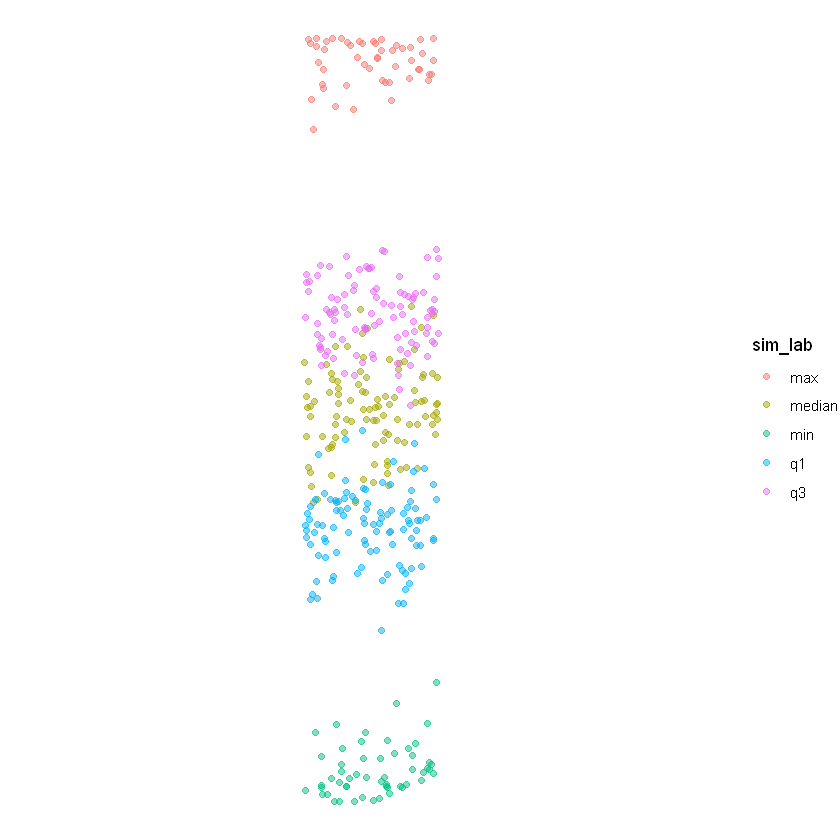

In [8]:
in_dat <- summary(box_plots$left)


median_r <- in_dat[3]
q1_r  <- in_dat[2]
q3_r  <- in_dat[5] 
min_r <- in_dat[1]
max_r <- in_dat[6]
sd_r <- abs(max_r-min_r)/20

npoints=100

d_median <- rnorm(npoints,median_r,sd_r)
d_q1 <- rnorm(npoints,q1_r,sd_r)
d_q3 <- rnorm(npoints,q3_r,sd_r)
d_min <- rnorm(npoints,min_r,sd_r)
d_max <- rnorm(npoints,max_r,sd_r)
sim      <- c(d_median,d_q1,d_q3,d_min,d_max)

lab_median <- rep("median",npoints)
lab_q1     <- rep("q1"    ,npoints)
lab_q3     <- rep("q3"    ,npoints)
lab_min     <- rep("min"  ,npoints)
lab_max     <- rep("max"  ,npoints)

sim_lab <- c(lab_median,lab_q1,lab_q3,lab_min,lab_max)
df_sim <- data.frame(sim,sim_lab)
df_sim_sel <- df_sim[df_sim$sim < max_r & df_sim$sim>min_r,]

psim <-ggplot(df_sim_sel, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							     +
       theme_void() +
	   xlim(-1, 3)

psim
	   
summary(df_sim_sel$sim)

so the plot is almost there but the data are still _not ok_ now we create a function, add points and create a bit of benchmarks and also plots.starting with the function


In [9]:

boxSim <- function(npoints,med = median_r,
				   q1 = q1_r,
				   q3 = q3_r,
				   mmin = min_r,
				   mmax = max_r,
				   sdr = c(2,2,2,2,2))
{

d_median <- rnorm(npoints,med,sdr[1])
d_q1 <- rnorm(npoints,q1,sdr[2])
d_q3 <- rnorm(npoints,q3,sdr[3])
d_min <- rnorm(npoints,mmin,sdr[4])
d_max <- rnorm(npoints,mmax,sdr[5])

sim      <- c(d_median,d_q1,d_q3,d_min,d_max)

lab_median <- rep("median",npoints)
lab_q1     <- rep("q1"    ,npoints)
lab_q3     <- rep("q3"    ,npoints)
lab_min     <- rep("min"  ,npoints)
lab_max     <- rep("max"  ,npoints)

sim_lab <- c(lab_median,lab_q1,lab_q3,lab_min,lab_max)
df_sim <- data.frame(sim,sim_lab)
df_sim_sel <- df_sim[df_sim$sim < mmax & df_sim$sim>mmin,]

return(df_sim_sel)
}


now everything is more flexible since we can give each of the `median`,`q1`,`q3`,`min`,`max` its own variance and create 
even more combinations (keeping "everything symmetric")


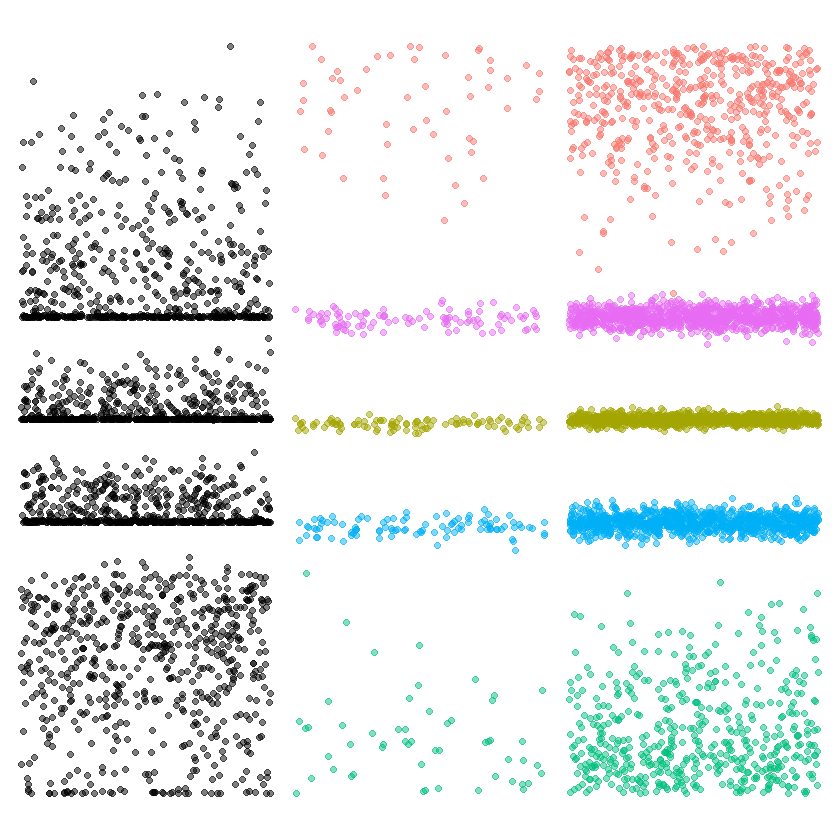

In [10]:
#our imput data
median_r <- in_dat[3]
q1_r  <- in_dat[2]
q3_r  <- in_dat[5] 
min_r <- in_dat[1]
max_r <- in_dat[6]
sd_r <- abs(max_r-min_r)/10


n_points = c(100,1000,5000)



t100 <- boxSim(100,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))
t1k  <- boxSim(1000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))
t5k  <- boxSim(50000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))

t100_2 <- boxSim(100,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))
t1k_2  <- boxSim(1000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))
t5k_2 <- boxSim(50000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))

ptest <-ggplot(t100, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   xlim(-1, 3)


legend <- cowplot::get_legend(ptest)	  

datr <- data.table(box_plots$left)
colnames(datr) <- c("y")
pref <-  ggplot(datr, aes(x = 1, y = y )) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt100 <-ggplot(t100, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt1k <-ggplot(t1k, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")
	   
pt5k <-ggplot(t5k, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt100_2 <-ggplot(t100_2, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt1k_2 <-ggplot(t1k_2, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")
	   
pt5k_2 <-ggplot(t5k_2, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

library(patchwork)

pref + pt100 + pt1k 



*note about the code*: I prefer not to plot the 50K due to speed problem but you can try to see how it looks

also we can see in numbers what is happening 

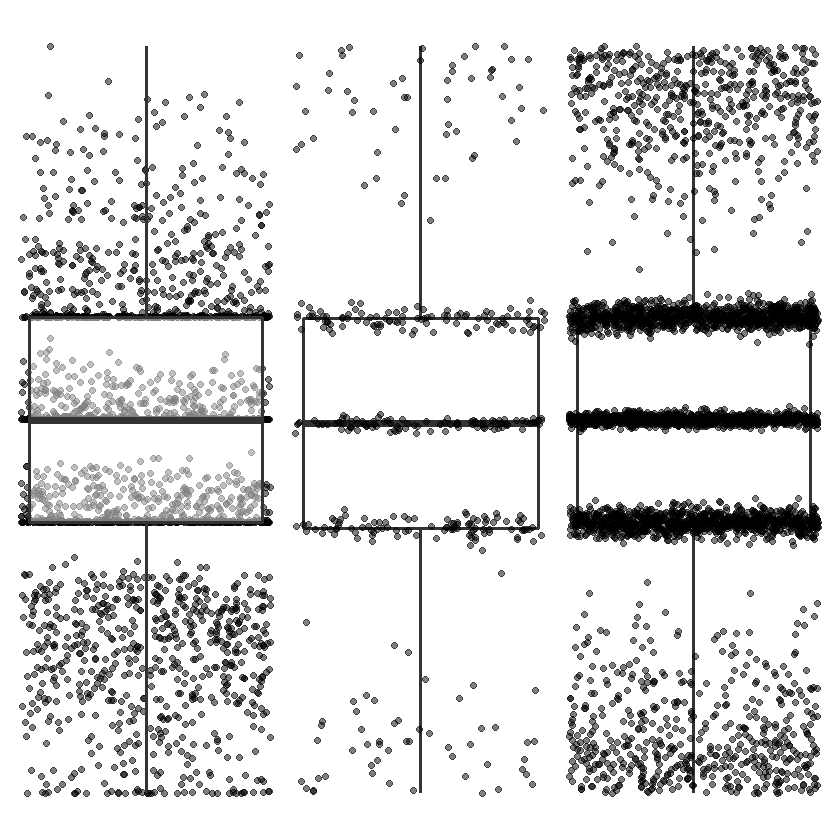

In [11]:
pb1 <- pref + geom_boxplot(lwd=1, alpha=0.5) 
pb2 <- ggplot(t100, aes(x = 1, y =sim)) + geom_boxplot(lwd=1) + geom_jitter(alpha=0.5) + theme_void() +
       theme(legend.position = "none")
pb3 <- ggplot(t1k, aes(x = 1, y =sim)) + geom_boxplot(lwd=1) + geom_jitter(alpha=0.5) + theme_void() +
       theme(legend.position = "none")

pb1+pb2+pb3

In [12]:
refdf <- data.frame(unclass(summary(datr)))
colnames(refdf) <- ("refdf")

library(foreach)

test <- foreach(i=seq(1000,20000,5000)) %do% boxSim(i,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))
res <- lapply(seq(1,length(test)), function(x) summary(test[[x]]$sim))
res <- lapply(seq(1,length(test)), function(x) data.frame(unclass(summary(test[[x]]$sim)), check.names = FALSE, stringsAsFactors = FALSE) )
res.dat <- data.frame(res)
              
colnames(res.dat) <- as.character(paste0("npoints_",seq(1000,20000,5000)))

r1 <- data.frame(refdf,res.dat)

test2 <- foreach(i=seq(1000,20000,5000)) %do% boxSim(i,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))
res2 <- lapply(seq(1,length(test)), function(x) summary(test[[x]]$sim))
res2 <- lapply(seq(1,length(test)), function(x) data.frame(unclass(summary(test2[[x]]$sim)), check.names = FALSE, stringsAsFactors = FALSE) )
res2.dat <- data.frame(res2)
colnames(res2.dat) <- as.character(paste0("npoints_",seq(1000,20000,5000)))

r2 <- data.frame(refdf,res.dat)

r1
r2
 

,refdf,npoints_1000,npoints_6000,npoints_11000,npoints_16000
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
X,Min. :-9.76964,-9.76023094,-9.76963778,-9.769639869,-9.7693364188
X.1,1st Qu.:-2.68999,-2.70158946,-2.69077069,-2.684025027,-2.6887801509
X.2,Median :-0.00999,-0.01193060,-0.01039673,-0.009155821,-0.0100266987
X.3,Mean :-1.17780,-0.05444261,-0.02459862,0.006118239,0.0008133544
X.4,3rd Qu.: 2.67007,2.67536563,2.66585932,2.665907452,2.6710984241
X.5,Max. : 9.75025,9.74717550,9.74978454,9.749191820,9.7501415131


,refdf,npoints_1000,npoints_6000,npoints_11000,npoints_16000
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
X,Min. :-9.76964,-9.76023094,-9.76963778,-9.769639869,-9.7693364188
X.1,1st Qu.:-2.68999,-2.70158946,-2.69077069,-2.684025027,-2.6887801509
X.2,Median :-0.00999,-0.01193060,-0.01039673,-0.009155821,-0.0100266987
X.3,Mean :-1.17780,-0.05444261,-0.02459862,0.006118239,0.0008133544
X.4,3rd Qu.: 2.67007,2.67536563,2.66585932,2.665907452,2.6710984241
X.5,Max. : 9.75025,9.74717550,9.74978454,9.749191820,9.7501415131


whit this very brutal test we can see that *1000 points are enough to obtain an acceptable random dataset with predefined stats*.
Also the fun is that changing seeds everytime we have a different dataset.so the mainly advantages are
- extremely fast
- can generate dataset with different datapoints in comparison with the starting dataset
- can use also different distributions (need to keep data "symmetry")
Probably also this can be a starting point for applying a simulated annealing after. Or this very simple stragegy can be employed for other problems.